Importing all libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import gzip
import os
import shutil
import matplotlib.font_manager as font_manager
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


loading the dataset

In [2]:
!wget http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/data/listings.csv.gz
os.rename("listings.csv.gz", "/content/listings.csv.gz")
shutil.move("listings.csv.gz", "/content/listings.csv.gz")
os.replace("listings.csv.gz", "/content/listings.csv.gz")

--2021-01-28 09:09:16--  http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.217.102.27
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.217.102.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27166880 (26M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz     100%[===================>]  25.91M  20.2MB/s    in 1.3s    

2021-01-28 09:09:18 (20.2 MB/s) - ‘listings.csv.gz’ saved [27166880/27166880]



Unzipping the file

In [3]:
with gzip.open('/content/listings.csv.gz', 'rb') as f_in:
    with open('/content/listings.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Reading the data

In [4]:
data = pd.read_csv('/content/listings.csv')
data.shape

(44666, 74)

Dropping the unneccesary fields and cleaning the data

In [5]:
data = data.drop(['id','listing_url','scrape_id','last_scraped','name','neighborhood_overview','picture_url','host_id','host_url','host_name',
                  'host_since','host_location','host_about','host_is_superhost','host_thumbnail_url','host_picture_url','host_listings_count',
                  'host_verifications','host_has_profile_pic','calendar_last_scraped','first_review','last_review',
                  'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
                  'calculated_host_listings_count_shared_rooms','license','bathrooms', 'calendar_updated', 'has_availability','host_total_listings_count',
                  'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                  'minimum_nights_avg_ntm','maximum_nights_avg_ntm','number_of_reviews_ltm','number_of_reviews_l30d'], 
                axis=1)
data.dtypes

description                        object
host_response_time                 object
host_response_rate                 object
host_acceptance_rate               object
host_neighbourhood                 object
host_identity_verified             object
neighbourhood                      object
neighbourhood_cleansed             object
neighbourhood_group_cleansed       object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bathrooms_text                     object
bedrooms                          float64
beds                              float64
amenities                          object
price                              object
minimum_nights                      int64
availability_30                     int64
availability_60                     int64
availability_90                     int64
availability_365                  

In [6]:
data.shape

(44666, 35)

In [7]:
data['description'] = data['description'].fillna(' ')
data.description

0        Beautiful, spacious skylit studio in the heart...
1        Enjoy 500 s.f. top floor in 1899 brownstone, w...
2        <b>The space</b><br />HELLO EVERYONE AND THANK...
3        We welcome you to stay in our lovely 2 br dupl...
4        Please don’t expect the luxury here just a bas...
                               ...                        
44661    The unit is located on the 3rd floor in Lennox...
44662                                                     
44663    Newly renovated 2 Bedroom apartment with great...
44664    Very clean Apartment , nice and cozy  I have a...
44665    Fully furnished and stocked, flexible 1-18 mon...
Name: description, Length: 44666, dtype: object

Applying textblob for sentiment analysis

In [8]:
from textblob import TextBlob

data['sentiment'] = data['description'].apply(lambda desc: TextBlob(desc).polarity)
data.describe()

,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,sentiment
count,44666.000000,44666.000000,44666.000000,40407.000000,44153.000000,44666.000000,44666.000000,44666.000000,44666.000000,44666.000000,44666.000000,33102.000000,33070.000000,33083.000000,33055.000000,33075.000000,33050.000000,33051.000000,44666.000000,34149.000000,44666.000000
mean,40.729714,-73.950756,2.758250,1.291880,1.507304,9.301191,8.137621,18.572180,29.672413,105.422447,22.456992,93.849435,9.599546,9.268930,9.724459,9.727498,9.594191,9.386070,6.668338,0.864005,0.252108
std,0.055180,0.047505,1.803448,0.681161,1.090736,24.232548,12.057353,24.987269,37.929037,139.519399,46.664551,9.418724,0.919346,1.143005,0.810329,0.827889,0.800604,0.986716,24.854672,1.267115,0.137028
min,40.508680,-74.239860,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000,-0.500000
25%,40.689880,-73.982980,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.110000,0.170914
50%,40.724560,-73.955285,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,4.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.350000,0.250685
75%,40.763350,-73.933980,4.000000,1.000000,2.000000,7.000000,20.000000,47.000000,73.000000,189.000000,20.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.130000,0.331818
max,40.911690,-73.711930,16.000000,21.000000,40.000000,1250.000000,30.000000,60.000000,90.000000,365.000000,746.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,239.000000,41.370000,1.000000


Converting 'Instant bookable' field to Int 

In [9]:
data.loc[data['instant_bookable'] == 'f',['instant_bookable']] = '0'
data.loc[data['instant_bookable'] == 't',['instant_bookable']] = '1'
data.instant_bookable = data.instant_bookable.astype(int)

Converting 'Host responce rate' field to Float

In [10]:
data['host_response_rate'] = data['host_response_rate'].str.replace("%", "").astype("float")
data['host_response_rate'].fillna(value=np.mean(data['host_response_rate']), inplace=True)

Cleaning the price field 

In [11]:
data['price'] = data['price'].str.replace('$', '')
data['price'] = data['price'].str.replace(',', '')
data["price"] = pd.to_numeric(data["price"], downcast="float")
data = data[data.price > 0]
data.isnull().sum().sort_values(ascending=False)
data.describe()

,host_response_rate,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,sentiment
count,44641.000000,44641.000000,44641.000000,44641.000000,40403.000000,44148.000000,44641.000000,44641.000000,44641.000000,44641.000000,44641.000000,44641.000000,44641.000000,33098.000000,33066.000000,33079.000000,33051.000000,33071.000000,33046.000000,33047.000000,44641.000000,44641.000000,34145.000000,44641.000000
mean,86.292654,40.729706,-73.950736,2.758272,1.291909,1.507316,150.188721,9.305661,8.142179,18.582581,29.689030,105.479156,22.468941,93.850565,9.599649,9.268902,9.724456,9.727526,9.594202,9.386177,0.337067,6.670146,0.864013,0.252241
std,18.731282,0.055193,0.047510,1.803325,0.681188,1.090785,323.438934,24.238579,12.059190,24.990399,37.933153,139.537692,46.674780,9.417203,0.919243,1.143058,0.810364,0.827881,0.800632,0.986651,0.472713,24.861435,1.267149,0.136948
min,0.000000,40.508680,-74.239860,1.000000,1.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,1.000000,0.010000,-0.500000
25%,86.293973,40.689870,-73.982950,2.000000,1.000000,1.000000,64.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.000000,1.000000,0.110000,0.171155
50%,86.293973,40.724550,-73.955270,2.000000,1.000000,1.000000,100.000000,3.000000,0.000000,0.000000,0.000000,1.000000,4.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,1.000000,0.350000,0.250794
75%,100.000000,40.763350,-73.933950,4.000000,1.000000,2.000000,160.000000,7.000000,20.000000,47.000000,73.000000,189.000000,20.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,2.000000,1.130000,0.331860
max,100.000000,40.911690,-73.711930,16.000000,21.000000,40.000000,10000.000000,1250.000000,30.000000,60.000000,90.000000,365.000000,746.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,239.000000,41.370000,1.000000


Changing values for 'Host identity verified' field from 'True/False' to 0/1 

In [12]:
data.loc[data['host_identity_verified'] == 'f',['host_identity_verified']] = '0'
data.loc[data['host_identity_verified'] == 't',['host_identity_verified']] = '1'
data.instant_bookable = data.instant_bookable.astype(int)
data['host_identity_verified'].fillna(0, inplace=True)

In [13]:
data.shape

(44641, 36)

Price outlier Analysis 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 21.295889
Kurtosis: 587.172180


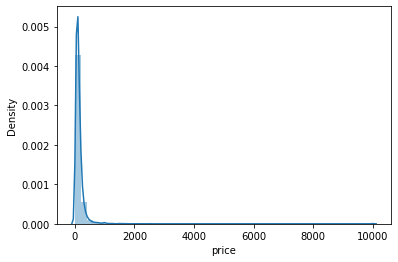

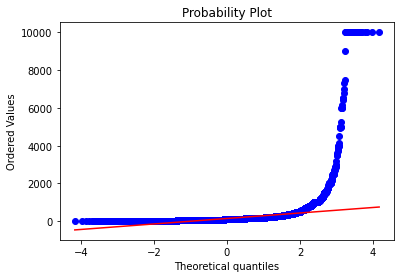

In [14]:
sns.distplot(data['price'], kde=True,);
fig = plt.figure()
res = stats.probplot(data['price'], plot=plt)
print("Skewness: %f" % data['price'].skew())
print("Kurtosis: %f" % data['price'].kurt())

In [15]:
data = data[data.price <= 600]
data.shape

(43824, 36)

Skewness: 1.931983
Kurtosis: 4.792629


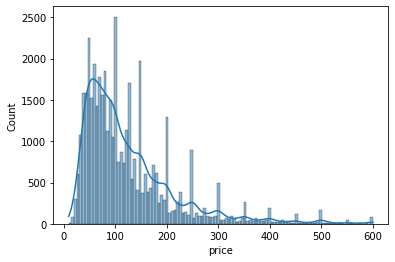

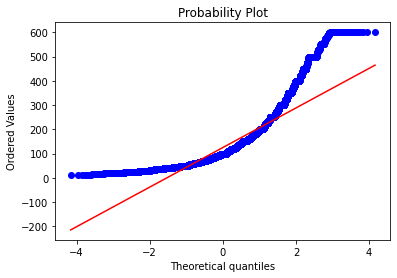

In [16]:
sns.histplot(data['price'], kde=True,);
fig = plt.figure()
res = stats.probplot(data['price'], plot=plt)
print("Skewness: %f" % data['price'].skew())
print("Kurtosis: %f" % data['price'].kurt())

Cleaning the bedroom field

In [17]:
data['bedrooms'].fillna(0, inplace=True)
data.fillna(0, inplace=True)
data = data[data.beds > 0]
data.loc[data['bedrooms'] == 0, 'bedrooms'] = 1.0
data.head()


,description,host_response_time,host_response_rate,host_acceptance_rate,host_neighbourhood,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,sentiment
0,"Beautiful, spacious skylit studio in the heart...",within a day,70.000000,25%,Midtown,1,"New York, United States",Midtown,Manhattan,40.75362,-73.98377,Entire apartment,Entire home/apt,2,1 bath,1.0,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",175.0,3,30,60,90,365,48,94.0,9.0,9.0,10.0,10.0,10.0,9.0,0,2,0.36,0.320801
1,"Enjoy 500 s.f. top floor in 1899 brownstone, w...",within an hour,98.000000,96%,Clinton Hill,1,"Brooklyn, New York, United States",Clinton Hill,Brooklyn,40.68514,-73.95976,Entire guest suite,Entire home/apt,3,1 bath,1.0,3.0,"[""Hot water"", ""Stove"", ""Free parking on premis...",76.0,1,2,2,2,2,354,89.0,8.0,9.0,9.0,9.0,9.0,9.0,0,1,4.82,0.167500
2,<b>The space</b><br />HELLO EVERYONE AND THANK...,0,86.293973,100%,Bedford-Stuyvesant,1,0,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,Private room in apartment,Private room,2,0,1.0,1.0,"[""Wifi"", ""Air conditioning"", ""Heating"", ""Kitch...",60.0,29,2,2,2,2,50,90.0,8.0,8.0,10.0,10.0,9.0,9.0,0,1,0.36,0.244417
3,We welcome you to stay in our lovely 2 br dupl...,within a few hours,100.000000,0,Greenwood Heights,0,0,Sunset Park,Brooklyn,40.66120,-73.99423,Entire apartment,Entire home/apt,4,1.5 baths,2.0,2.0,"[""Wifi"", ""Dryer"", ""Air conditioning"", ""Kitchen...",175.0,7,24,54,84,359,1,97.0,10.0,10.0,10.0,10.0,8.0,10.0,0,1,0.01,0.227548
4,Please don’t expect the luxury here just a bas...,within a few hours,100.000000,100%,Hell's Kitchen,0,"New York, United States",Hell's Kitchen,Manhattan,40.76489,-73.98493,Private room in apartment,Private room,2,1 bath,1.0,1.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""Paid ...",73.0,2,29,53,78,350,473,84.0,9.0,7.0,9.0,9.0,10.0,9.0,0,1,3.40,0.046753


In [18]:
data.isnull().sum()

description                       0
host_response_time                0
host_response_rate                0
host_acceptance_rate              0
host_neighbourhood                0
host_identity_verified            0
neighbourhood                     0
neighbourhood_cleansed            0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms_text                    0
bedrooms                          0
beds                              0
amenities                         0
price                             0
minimum_nights                    0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness   

Categorical data for neighbourhood 

In [19]:
data['neighbourhood_group_cleansed'].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [20]:
data['neighbourhood_group_cleansed'] = data['neighbourhood_group_cleansed'].astype('category')
data.dtypes

description                         object
host_response_time                  object
host_response_rate                 float64
host_acceptance_rate                object
host_neighbourhood                  object
host_identity_verified              object
neighbourhood                       object
neighbourhood_cleansed              object
neighbourhood_group_cleansed      category
latitude                           float64
longitude                          float64
property_type                       object
room_type                           object
accommodates                         int64
bathrooms_text                      object
bedrooms                           float64
beds                               float64
amenities                           object
price                              float32
minimum_nights                       int64
availability_30                      int64
availability_60                      int64
availability_90                      int64
availabilit

assiging cat codes to categorical data

In [21]:
data['neighbourhood_group_cleansed'] = data['neighbourhood_group_cleansed'].cat.codes
data['neighbourhood_group_cleansed']

0        2
1        1
2        1
3        1
4        2
        ..
44659    3
44662    2
44663    1
44664    2
44665    2
Name: neighbourhood_group_cleansed, Length: 41780, dtype: int8

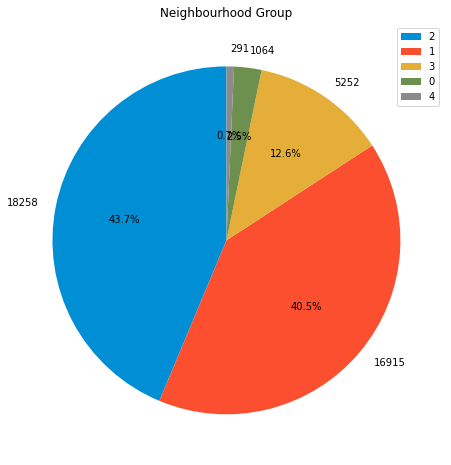

In [22]:
labels = data.neighbourhood_group_cleansed.value_counts().index
colors = ['#008fd5','#fc4f30','#e5ae38','#6d904f','#8b8b8b']

shape = data.neighbourhood_group_cleansed.value_counts().values
plt.figure(figsize=(8,8))
plt.pie(shape, labels=shape, colors= colors, autopct = '%1.1f%%', startangle=90)
plt.legend(labels)
plt.title('Neighbourhood Group')
plt.show()

Categorical data for room types

In [23]:
data['room_type'] = data['room_type'].astype('category')
data.dtypes

description                         object
host_response_time                  object
host_response_rate                 float64
host_acceptance_rate                object
host_neighbourhood                  object
host_identity_verified              object
neighbourhood                       object
neighbourhood_cleansed              object
neighbourhood_group_cleansed          int8
latitude                           float64
longitude                          float64
property_type                       object
room_type                         category
accommodates                         int64
bathrooms_text                      object
bedrooms                           float64
beds                               float64
amenities                           object
price                              float32
minimum_nights                       int64
availability_30                      int64
availability_60                      int64
availability_90                      int64
availabilit

In [24]:
data['room_type'] = data['room_type'].cat.codes
data['room_type']

0        0
1        0
2        2
3        0
4        2
        ..
44659    0
44662    0
44663    0
44664    2
44665    2
Name: room_type, Length: 41780, dtype: int8

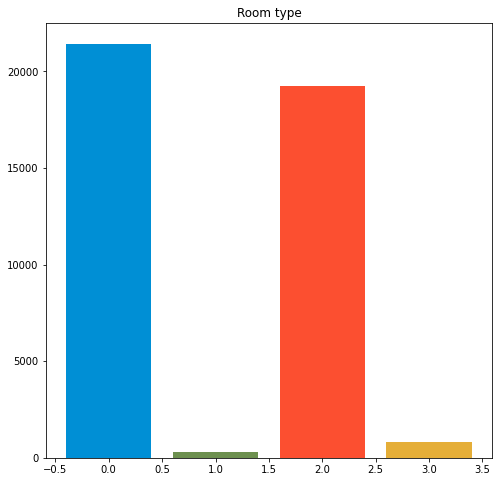

In [25]:
labels = data.room_type.value_counts().index

colors = ['#008fd5','#fc4f30','#e5ae38','#6d904f']

shape = data.room_type.value_counts().values

plt.figure(figsize=(8,8))
plt.bar(labels, shape, color=colors)
plt.title('Room type')
plt.show()

Corelation matrix 

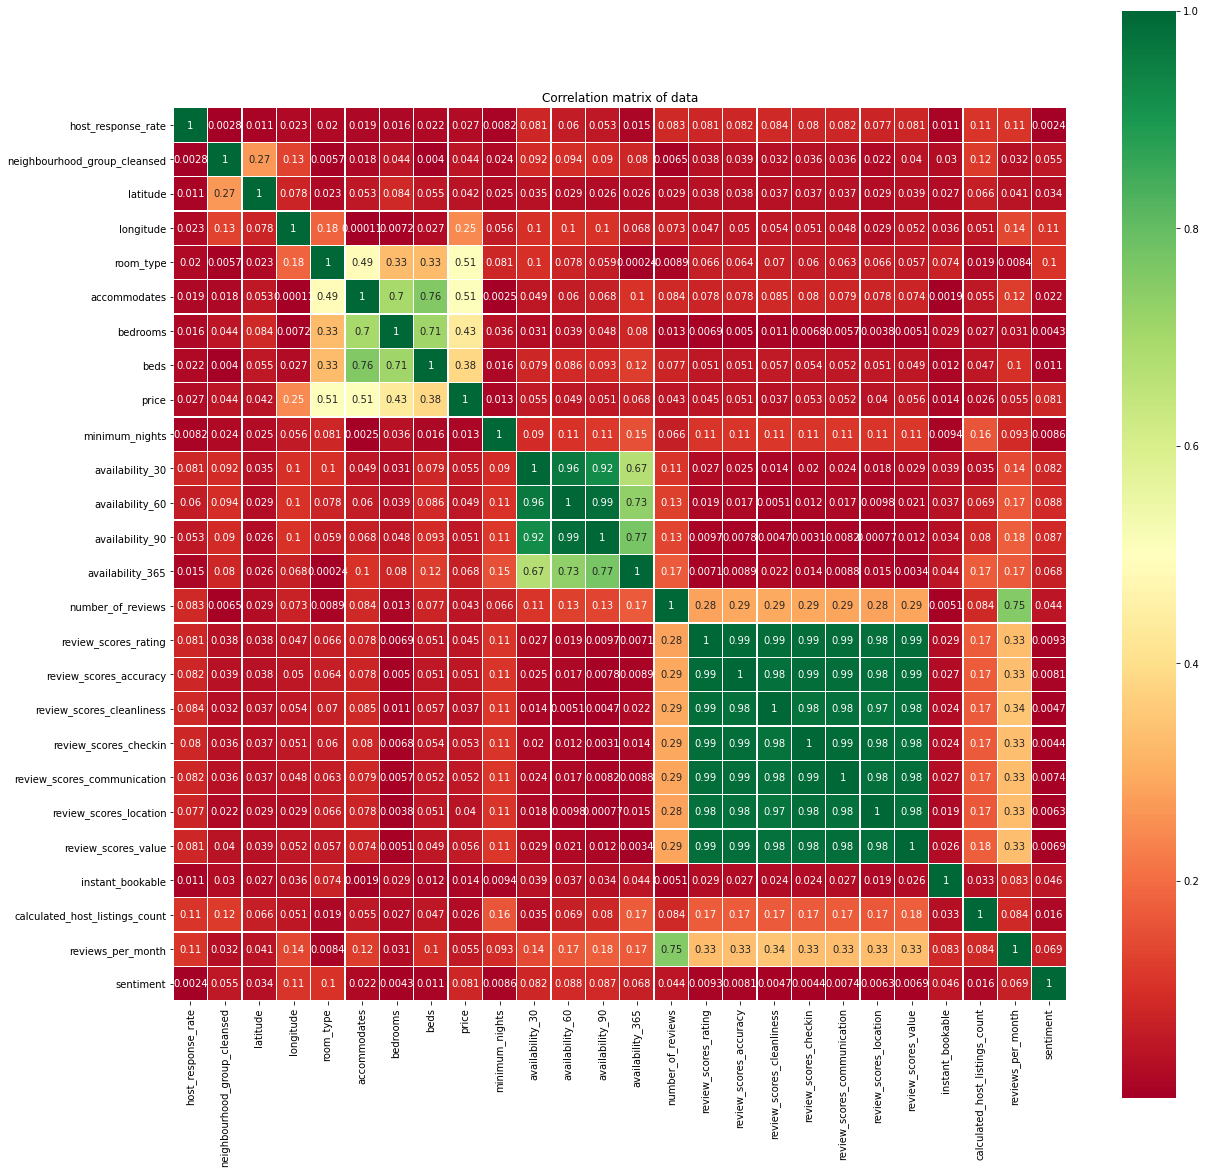

In [26]:
corr_matrix = abs(data.corr())
plt.figure(figsize=(20,20))
title = 'Correlation matrix of data'
sns.heatmap(corr_matrix,linewidths=0.25,vmax=1.0, square=True, cmap='RdYlGn',annot=True)
plt.title(title)
plt.ioff()

In [27]:
corr_matrix['price'].sort_values(ascending=False)

price                             1.000000
accommodates                      0.507079
room_type                         0.505461
bedrooms                          0.431505
beds                              0.384550
longitude                         0.246035
sentiment                         0.081163
availability_365                  0.067986
review_scores_value               0.055931
reviews_per_month                 0.055240
availability_30                   0.055239
review_scores_checkin             0.052686
review_scores_communication       0.052433
availability_90                   0.051495
review_scores_accuracy            0.050581
availability_60                   0.048947
review_scores_rating              0.045069
neighbourhood_group_cleansed      0.043901
number_of_reviews                 0.043117
latitude                          0.041695
review_scores_location            0.039972
review_scores_cleanliness         0.037064
host_response_rate                0.026924
calculated_

Applying Lasso

In [28]:
newData = data.select_dtypes(exclude='object')
newData.fillna(0, inplace=True)
newData.isnull().sum()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


host_response_rate                0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
room_type                         0
accommodates                      0
bedrooms                          0
beds                              0
price                             0
minimum_nights                    0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location            0
review_scores_value               0
instant_bookable                  0
calculated_host_listings_count    0
reviews_per_month                 0
sentiment                         0
dtype: int64

In [29]:
X = newData.iloc[:, newData.columns != 'price']
Y = newData.iloc[:, newData.columns == 'price']
Y

,price
0,175.0
1,76.0
2,60.0
3,175.0
4,73.0
...,...
44659,126.0
44662,200.0
44663,92.0
44664,120.0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
std = StandardScaler()
std.fit(X_train.values)
X_tr_train = std.transform(X_train.values)
X_tr_test = std.transform(X_test.values)

In [31]:
alphavec = 10**np.linspace(-2,2,200)
lasso_model_census = LassoCV(alphas = alphavec, cv=5)
lasso_model_census.fit(X_tr_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [32]:
lasso_betas = list(zip(X_train.columns,
lasso_model_census.coef_))# R2 of Training set
lasso_model_census.score(X_tr_train,y_train)

0.4311777192964117

In [33]:
lasso_betas

[('host_response_rate', -1.4265300455536254),
 ('neighbourhood_group_cleansed', 4.861287158399593),
 ('latitude', 6.207902254458931),
 ('longitude', -17.501504991379147),
 ('room_type', -27.276735632455765),
 ('accommodates', 23.83710397654729),
 ('bedrooms', 16.177100217768462),
 ('beds', -2.7558555403102147),
 ('minimum_nights', -4.818272617449799),
 ('availability_30', 21.405469444269627),
 ('availability_60', -17.635554768271916),
 ('availability_90', 3.9431387685669224),
 ('availability_365', -0.11989183341319604),
 ('number_of_reviews', 0.21588417586861022),
 ('review_scores_rating', 17.810939332071197),
 ('review_scores_accuracy', -6.608031236627313),
 ('review_scores_cleanliness', 22.027533775593856),
 ('review_scores_checkin', -12.243289064122528),
 ('review_scores_communication', -22.48750005118473),
 ('review_scores_location', 22.583944730889574),
 ('review_scores_value', -25.391925584432066),
 ('instant_bookable', 1.450409035312606),
 ('calculated_host_listings_count', 1.09

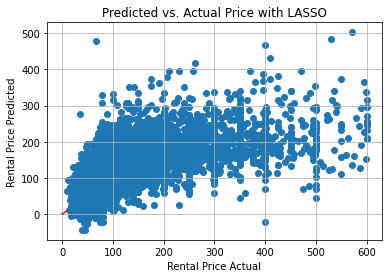

In [34]:
y_pred = lasso_model_census.predict(X_tr_test)
y_pred = y_pred.reshape(len(y_pred), 1)
r2_score(y_test, y_pred)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
    
mae(y_test, y_pred)
plt.scatter(y_test, y_pred)
plt.plot([0,10],[0,10],color='red')
plt.grid(True)
plt.title('Predicted vs. Actual Price with LASSO')
plt.ylabel('Rental Price Predicted')
plt.xlabel('Rental Price Actual');

Taking the important fields affecting Prices

In [35]:
X = data.loc[:,['accommodates','neighbourhood_group_cleansed','room_type',
                'bedrooms','beds','availability_30','review_scores_rating',
                'review_scores_cleanliness','review_scores_location',
                'instant_bookable', 'number_of_reviews','minimum_nights',
                'calculated_host_listings_count','latitude','longitude','sentiment'
                ]].values
y = data['price'].values
y = np.log10(y)
X.shape

(41780, 16)

Seperating the data into Train and Test set

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Linear regression Model

In [37]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
y_test.shape

(8356,)

In [38]:
lr_matrix = pd.DataFrame({'Actual': np.round(10 ** y_test, 0), 
                       'Predicted': np.round(10 ** y_pred, 0)})
lr_matrix.head(10)

,Actual,Predicted
0,160.0,105.0
1,200.0,71.0
2,175.0,116.0
3,60.0,114.0
4,175.0,138.0
5,72.0,70.0
6,51.0,64.0
7,206.0,105.0
8,150.0,211.0
9,96.0,112.0


Result

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import r2_score
print('Price mean:', np.round(np.mean(y), 2))  
print('Price std:', np.round(np.std(y), 2))
print('RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, linear_reg.predict(X_test))), 2))
print('R2 score train:', np.round(r2_score(y_train, linear_reg.predict(X_train), multioutput='variance_weighted'), 2))
print('R2 score test:', np.round(r2_score(y_test, linear_reg.predict(X_test), multioutput='variance_weighted'), 2))

Price mean: 2.01
Price std: 0.28
RMSE: 0.19
R2 score train: 0.53
R2 score test: 0.53


No handles with labels found to put in legend.


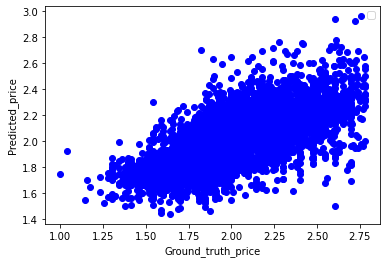

In [40]:
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel('Ground_truth_price')
plt.ylabel('Predicted_price')
plt.legend()
plt.show()

Ridge Regression Model

In [41]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)

In [42]:
rd_matrix = pd.DataFrame({'Actual': np.round(10 ** y_test, 0), 
                       'Predicted': np.round(10 ** y_pred, 0)})
rd_matrix.head(10)

,Actual,Predicted
0,160.0,105.0
1,200.0,71.0
2,175.0,116.0
3,60.0,113.0
4,175.0,137.0
5,72.0,70.0
6,51.0,64.0
7,206.0,105.0
8,150.0,211.0
9,96.0,112.0


Result

In [43]:
print('Price mean:', np.round(np.mean(y), 2))  
print('Price std:', np.round(np.std(y), 2))
print('RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, ridge_reg.predict(X_test))), 2))
print('R2 score train:', np.round(r2_score(y_train, ridge_reg.predict(X_train), multioutput='variance_weighted'), 2))
print('R2 score test:', np.round(r2_score(y_test, ridge_reg.predict(X_test), multioutput='variance_weighted'), 2))

Price mean: 2.01
Price std: 0.28
RMSE: 0.19
R2 score train: 0.53
R2 score test: 0.53


No handles with labels found to put in legend.


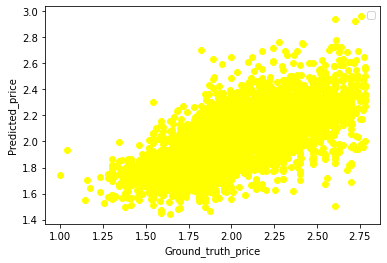

In [44]:
plt.scatter(y_test, y_pred, color='yellow')
plt.xlabel('Ground_truth_price')
plt.ylabel('Predicted_price')
plt.legend()
plt.show()

Support Vector Regression

In [45]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
stan_sc = StandardScaler()
X_train = stan_sc.fit_transform(X_train)
X_test  = stan_sc.transform(X_test)


In [46]:
svr_regressor = SVR(kernel='rbf')
svr_regressor.fit(X_train,y_train)
y_pred = svr_regressor.predict(X_test)

In [47]:
svr_regressor.score(X_test, y_test)

0.6629114249576599

Result

In [48]:
print('Price mean:', np.round(np.mean(y), 2))  
print('Price std:', np.round(np.std(y), 2))
print('RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, svr_regressor.predict(X_test))), 2))
print('R2 score train:', np.round(r2_score(y_train, svr_regressor.predict(X_train), multioutput='variance_weighted'), 2))
print('R2 score test:', np.round(r2_score(y_test, svr_regressor.predict(X_test), multioutput='variance_weighted'), 2))

Price mean: 2.01
Price std: 0.28
RMSE: 0.16
R2 score train: 0.7
R2 score test: 0.66


In [49]:
rd_matrix = pd.DataFrame({'Actual': np.round(10 ** y_test, 0), 
                       'Predicted': np.round(10 ** y_pred, 0)})
rd_matrix.head(10)

,Actual,Predicted
0,160.0,124.0
1,200.0,76.0
2,175.0,91.0
3,60.0,68.0
4,175.0,160.0
5,72.0,70.0
6,51.0,59.0
7,206.0,128.0
8,150.0,247.0
9,96.0,110.0


In [50]:
print('Accuracy of logistic regression  classifier on test set: {:.2f}'.format(svr_regressor.score(X_test, y_test)))

Accuracy of logistic regression  classifier on test set: 0.66


No handles with labels found to put in legend.


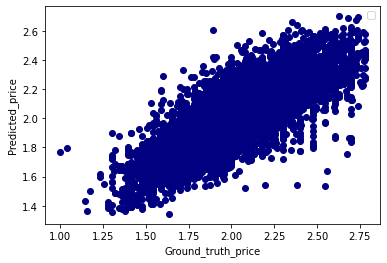

In [51]:
plt.scatter(y_test, y_pred, color='navy')
plt.xlabel('Ground_truth_price')
plt.ylabel('Predicted_price')
plt.legend()
plt.show()

Random forest method model

In [52]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(max_depth=8, n_estimators = 100, random_state = 0)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)
y_pred

array([2.1598295 , 1.8725513 , 2.06399247, ..., 1.8513777 , 1.87977483,
       1.86047491])

In [53]:
rf_matrix = pd.DataFrame({'Actual': np.round(10 ** y_test, 0), 
                   'Predicted': np.round(10 ** y_pred, 0)})
rf_matrix.head(10)

,Actual,Predicted
0,160.0,144.0
1,200.0,75.0
2,175.0,116.0
3,60.0,65.0
4,175.0,156.0
5,72.0,71.0
6,51.0,50.0
7,206.0,138.0
8,150.0,168.0
9,96.0,106.0


In [54]:
from sklearn.metrics import mean_absolute_error
print('Price mean:', np.round(np.mean(y), 2))  
print('Price std:', np.round(np.std(y), 2))
print('RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, rf_reg.predict(X_test))), 2))
print('R2 score train:', np.round(r2_score(y_train, rf_reg.predict(X_train), multioutput='variance_weighted'), 2))
print('R2 score test:', np.round(r2_score(y_test, rf_reg.predict(X_test), multioutput='variance_weighted'), 2))

Price mean: 2.01
Price std: 0.28
RMSE: 0.17
R2 score train: 0.67
R2 score test: 0.64


No handles with labels found to put in legend.


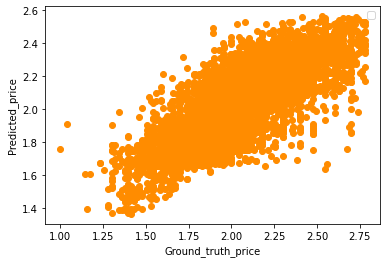

In [55]:
plt.scatter(y_test, y_pred, color='darkorange')
plt.xlabel('Ground_truth_price')
plt.ylabel('Predicted_price')
plt.legend()
plt.show()

In [56]:
rf_reg.score(X_test, y_test)

0.6438101589110767

In [57]:
print('Accuracy of logistic regression  classifier on test set: {:.2f}'.format(rf_reg.score(X_test, y_test)))

Accuracy of logistic regression  classifier on test set: 0.64


XGBoost Regression Model

In [58]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
stan_sc = StandardScaler()
X_train = stan_sc.fit_transform(X_train)
X_test  = stan_sc.transform(X_test)

In [59]:
from sklearn.model_selection import GridSearchCV
xg_booster = xgb.XGBRegressor()
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

grid_search = GridSearchCV(xg_booster, param_grid, cv=3, n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

[10:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [60]:
xg_booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, 
                           max_depth=9, n_estimators=150, random_state=4)
xg_booster.fit(X_train, y_train)
y_pred = xg_booster.predict(X_test)

[10:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [61]:
rf_matrix = pd.DataFrame({'Actual': np.round(10 ** y_test, 0), 
                   'Predicted': np.round(10 ** y_pred, 0)})
rf_matrix.head(10)

,Actual,Predicted
0,160.0,124.0
1,200.0,84.0
2,175.0,88.0
3,60.0,70.0
4,175.0,158.0
5,72.0,77.0
6,51.0,53.0
7,206.0,154.0
8,150.0,192.0
9,96.0,77.0


In [62]:
print('Price mean:', np.round(np.mean(y), 2))  
print('Price std:', np.round(np.std(y), 2))
print('RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, xg_booster.predict(X_test))), 2))
print('R2 score train:', np.round(r2_score(y_train, xg_booster.predict(X_train), multioutput='variance_weighted'), 2))
print('R2 score test:', np.round(r2_score(y_test, xg_booster.predict(X_test), multioutput='variance_weighted'), 2))

Price mean: 2.01
Price std: 0.28
RMSE: 0.16
R2 score train: 0.81
R2 score test: 0.7


In [63]:
print('Accuracy of logistic regression  classifier on test set: {:.2f}'.format(xg_booster.score(X_test, y_test)))

Accuracy of logistic regression  classifier on test set: 0.70


No handles with labels found to put in legend.


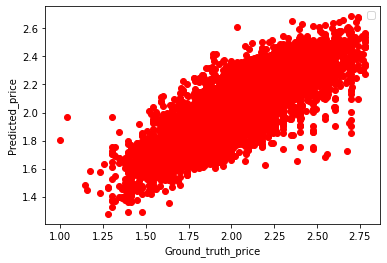

In [64]:
plt.scatter(y_test, y_pred, color='red')
plt.xlabel('Ground_truth_price')
plt.ylabel('Predicted_price')
plt.legend()
plt.show()